CarMDP Environment, which is provided for your convenience. You should not change code of this environment. Note that this CarMDP environment will be re-used for Asssignment 3 (Model-free). For Assignment 2 (Model-based), some parameters/functions may not be useful.  

This Jupyter notebook is prepared by Kui Wu

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import gym
import random

from gym import Env

class CarMDP(Env):
    """
    Car MDP with simple stochastic dynamics.
    The states are tuples with two elements:
        - a position index (i, j)
        - an integer from (0, 1, 2, 3) representing absolute orientation (see self.orientations in __init__ below)
    For example, the state
        s = (0, 1, 2)
    represents the car in the cell with indices (0, 1) and oriented to face the South.
    """
    def __init__(self, width, height, obstacles, goal_transition, initial_state, p_corr, base_reward=-0.01,
                 collision_reward=-5., goal_reward=10., stagnation_penalty=-0.01):
        self.width = width
        self.height = height
        self.grid_map = np.ones((width, height))
        for cell in obstacles:
            self.grid_map[cell[0], cell[1]] = 0.
        self.obstacles = obstacles
        self.orientations = {0: 'North', 1: 'East', 2: 'South', 3: 'West'}
        self.A = {0: 'Forward', 1: 'Left', 2: 'Right', 3: 'Brake'}
        self.goal_transition = goal_transition  # Tuple containing start and end state for the 'goal transition'

        self.p_corr = p_corr
        self.p_err = (1. - p_corr)/2.

        self.base_reward = base_reward
        self.collision_reward = collision_reward
        self.goal_reward = goal_reward
        self.stagnation_penalty = stagnation_penalty
        self.state_history = []
        self.action_history = []
        self.reward_history = []
        
        assert initial_state[0] >= 0 and initial_state[1] >= 0 and initial_state[0] < self.width and initial_state[1] < self.height and \
               initial_state[2] in self.orientations, "ERROR: initial state {:} is not valid.".format(initial_state)
        self.state_history = [initial_state]
        self.action_history = []
        self.reward_history = []
        self.init_state=initial_state
    
       
    def reset(self):
        self.state_history = [self.init_state]
        self.action_history = []
        self.reward_history = []

    def is_collision(self, state):
        is_out_of_bounds = state[0] < 0 or state[0] >= self.width or state[1] < 0 or \
             state[1] >= self.height
        return is_out_of_bounds or (state[0], state[1]) in self.obstacles

    def transition_dynamics(self, state, action):
        assert not self.is_collision(state), "ERROR: can't take an action from a non-state."
        delta = 1
        orientation = state[2]

        if self.orientations[orientation] == 'North':
            left = (state[0] - delta, state[1] - delta)
            forward = (state[0], state[1] - delta)
            right = (state[0] + delta, state[1] - delta)
        elif self.orientations[orientation] == 'West':
            left = (state[0] - delta, state[1] + delta)
            forward = (state[0] - delta, state[1])
            right = (state[0] - delta, state[1] - delta)
        elif self.orientations[orientation] == 'South':
            left = (state[0] + delta, state[1] + delta)
            forward = (state[0], state[1] + delta)
            right = (state[0] - delta, state[1] + delta)
        elif self.orientations[orientation] == 'East':
            left = (state[0] + delta, state[1] - delta)
            forward = (state[0] + delta, state[1])
            right = (state[0] + delta, state[1] + delta)

        # p gives categorical distribution over (state, left, forward, right)
        if self.A[action] == 'Forward':
            p = np.array([0., self.p_err, self.p_corr, self.p_err])
        elif self.A[action] == 'Right':
            p = np.array([0., 0., 2.*self.p_err, self.p_corr])
        elif self.A[action] == 'Left':
            p = np.array([0., self.p_corr, 2. * self.p_err, 0.])
        elif self.A[action] == 'Brake':
            p = np.array([self.p_corr, 0., 2. * self.p_err, 0.])

        candidate_next_state_positions = (state, left, forward, right)
        next_state_position = candidate_next_state_positions[categorical_sample_index(p)]

        # Handle orientation dynamics (deterministic)
        new_orientation = orientation
        if self.A[action] == 'Right':
            new_orientation = (orientation + 1) % 4
        elif self.A[action] == 'Left':
            new_orientation = (orientation - 1) % 4

        return next_state_position[0], next_state_position[1], new_orientation

    """The step function is useful for Assignment 3: model-free based sampling method"""
    def step(self, action):
        assert action in self.A, f"ERROR: action {action} not permitted"
        terminal = False
        current_state = self.state_history[-1] # -1 means the current element
        next_state = self.transition_dynamics(current_state, action)
        if self.is_collision(next_state):
            reward = self.collision_reward
            terminal = True
        elif (current_state[0], current_state[1]) == self.goal_transition[0] and \
                (next_state[0], next_state[1]) == self.goal_transition[1]:
            reward = self.goal_reward
            terminal = True  # TODO: allow multiple laps like this?
        elif current_state == next_state:
            reward = self.stagnation_penalty
            terminal = False
        else:
            reward = self.base_reward
            terminal = False

        self.state_history.append(next_state)
        self.reward_history.append(reward)
        self.action_history.append(action)

        return next_state, reward, terminal, []

    def render(self, title):
        self._plot_history(title)
    
    def _plot_history(self, title):
        """
        Plot the MDP's trajectory on the grid map.
        :param title:
        Note that the grid intersection points denote the position of location, e.g., [2,2] is the center of 
        an obstacle drawn in grey box.
        """
        
        fig = plt.figure()
        plt.imshow(self.grid_map.T, cmap='gray')
        plt.grid()
        fig.tight_layout()
        
        
        x = np.zeros(len(self.state_history))
        y = np.zeros(x.shape)
        for idx in range(len(x)):
            x[idx] = self.state_history[idx][0]
            y[idx] = self.state_history[idx][1]
            if self.state_history[idx][2] == 0:
                plt.arrow(x[idx], y[idx], 0., -0.25, width=0.1)
            elif self.state_history[idx][2] == 1:
                plt.arrow(x[idx], y[idx], 0.25, 0., width=0.1)
            elif self.state_history[idx][2] == 2:
                plt.arrow(x[idx], y[idx], 0., 0.25, width=0.1)
            else:
                plt.arrow(x[idx], y[idx], -0.25, 0., width=0.1)

        plt.plot(x, y, 'b-')  # Plot trajectory
        plt.xlim([-0.5, self.width + 0.5])
        plt.ylim([self.height + 0.5, -0.5])
        plt.title(title)
        plt.xlabel('x')
        plt.ylabel('y')
    
        
        plt.show()
        return fig


def categorical_sample_index(p: np.ndarray) -> int:
    """
    Sample a categorical distribution.

    :param p: a categorical distribution's probability mass function (i.e., p[idx] is the probability of this function
              returning idx for an integer 0 <= idx < len(p)). I.e., np.sum(p) == 1 and p[idx] >= 0 for 0<=idx<len(p).
    :return: index of a sample weighted by the categorical distribution described by p
    """
    P = np.cumsum(p)
    sample = np.random.rand()
    return np.argmax(P > sample)

Below is the skeleton code of your agent. Your solution should be filled here. In Assignment 2, we assume that the agent is aware of the model (e.g., the transition dynamics, the size of the state space, the rewards for actions, the obstacles). You need to (1) implement Iterative Policy Evaluation to find the state values for the Random policy (the policy that takes each action uniformly random among the four possible actions). Then, starting with the state values of the Random policy, you (2) implement the Policy Iteration method to find the optimal policy. Take your freedom to determine your criteria for convergence, which is part of the job in training machine learning models. 

In [22]:
from numpy.random.mtrand import set_state
from numpy.core.fromnumeric import argmax
class ModelBasedRLAgent:
    """
    Your implementation of a reinforcement learning agent.
    Feel free to add additional methods and attributes.
    """
    def __init__(self, car_mdp):
        ### STUDENT CODE GOES HERE
        # Set any parameters
        # You can add arguments to __init__, so log as they have default values (e.g., epsilon=0.1)
        self.env=car_mdp
        self.rand_policy = np.ones([self.env.width, self.env.height, len(self.env.orientations), len(self.env.A)]) / len(self.env.A) # random policy 
        self.action_value = np.zeros((self.env.width, self.env.height, len(self.env.orientations), len(self.env.A)))
        self.discount_factor = 1.0
        self.policy = self._valueEvaluation() # After this call, the optimal policy should be found and stored for test purpose. 
        for i in range(len(self.policy)):
            for j in range(len(self.policy[i])):
                for k in range(len(self.policy[i,j])):
                    print(i ,j ,k, self.env.A[np.argmax(self.policy[i,j,k])])
        #print(self.policy)

    def reset(self, init_state) -> int:
        """
        Called at the start of each episode.

        :param init_state:
        :return: first action to take.
        """
        ### STUDENT CODE GOES HERE
        return np.argmax(self.policy[init_state]) # Random policy (CHANGE THIS WITH THE OPTIMAL POLICY OBTAINED WITH VALUE ITERATION)
        
    
    def dynamics(self, state, action):
        delta = 1
        orientation = state[2]
        new_states = []
        next_states = []

        new_states.append(state)
        if self.env.orientations[orientation] == 'North':
            left = (state[0] - delta, state[1] - delta)
            forward = (state[0], state[1] - delta)
            right = (state[0] + delta, state[1] - delta)
        elif self.env.orientations[orientation] == 'West':
            left = (state[0] - delta, state[1] + delta)
            forward = (state[0] - delta, state[1])
            right = (state[0] - delta, state[1] - delta)
        elif self.env.orientations[orientation] == 'South':
            left = (state[0] + delta, state[1] + delta)
            forward = (state[0], state[1] + delta)
            right = (state[0] - delta, state[1] + delta)
        elif self.env.orientations[orientation] == 'East':
            left = (state[0] + delta, state[1] - delta)
            forward = (state[0] + delta, state[1])
            right = (state[0] + delta, state[1] + delta)
        
        new_orientation = orientation
        if self.env.A[action] == 'Right':
            new_orientation = (orientation + 1) % 4
        elif self.env.A[action] == 'Left':
            new_orientation = (orientation - 1) % 4

        new_states.append((left[0], left[1], new_orientation))
        new_states.append((forward[0], forward[1], new_orientation))
        new_states.append((right[0], right[1], new_orientation))

        if self.env.A[action] == 'Forward':
            p = np.array([0., self.env.p_err, self.env.p_corr, self.env.p_err])  
        elif self.env.A[action] == 'Right':
            p = np.array([0., 0., 2.*self.env.p_err, self.env.p_corr])
        elif self.env.A[action] == 'Left':
            p = np.array([0., self.env.p_corr, 2. * self.env.p_err, 0.])
        elif self.env.A[action] == 'Brake':
            p = np.array([self.env.p_corr, 0., 2. * self.env.p_err, 0.])
        

        for i in range(len(p)):
            if self.env.is_collision(new_states[i]):
                reward = self.env.collision_reward
            elif (state[0], state[1]) == self.env.goal_transition[0] and (new_states[i][0], new_states[i][1]) == self.env.goal_transition[1]:
                reward = self.env.goal_reward
            elif state == new_states[i]:
                reward = self.env.stagnation_penalty
            else:
                reward = self.env.base_reward

            next_states.append((p[i], new_states[i], reward, self.env.is_collision(new_states[i])))
        
        return next_states

    def _policyEvaluation(self, policy):
        #print("start eval")
        V = np.zeros((self.env.width, self.env.height, len(self.env.orientations)))
        V_new = np.copy(V)
        #print(V_new[0,0,0])
        theta = 0.1
        while True:
            delta = 0
            for i in range(len(policy)):
                for j in range(len(policy[i])):
                    for k in range(len(policy[i,j])):
                        v = 0
                        for a, pi_a in enumerate(policy[i,j,k]):
                            #print("action: ",a, pi_a)
                            for prob, next_state, reward, terminal in self.dynamics((i,j,k), a):
                                if self.env.is_collision(next_state):
                                    v += pi_a * prob * (reward + self.discount_factor * 0)
                                else:
                                    v += pi_a * prob * (reward + self.discount_factor * V[next_state])
                                    #print("temp v: ", v)
                        #print("v value: ",v)
                        V_new[i,j,k] = v
                        delta = max(delta, np.abs(V_new[i,j,k] - V[i,j,k]))
            #print(V)
            V = np.copy(V_new)
            #print(delta, theta)
            if delta < theta:
                break
        #print("end eval")
        return V
    
    def argmax_a(self, arr):
  
        max_idx = []
        max_val = float('-inf')
        for idx, elem in enumerate(arr):
            if elem == max_val:
                max_idx.append(idx)
            elif elem > max_val:
                max_idx = [idx]
                max_val = elem
        return max_idx                
                    

        ### STUDENT CODE GOES HERE
        #replaced with your code
        ### YOU NEED TO PRINT OUT THE FINAL OUTPUT OF STATE VALUES 
        ### IN THE FORMAT OF [STATE: VALUE] WHERE STATE IS DENOTED BY (X,Y,ORITENTATION)
    def _policyImprovement(self, policy, V_func):
        policy_stable = False
        Q = np.zeros((self.env.width, self.env.height, len(self.env.orientations), len(self.env.A)))
        new_policy = np.zeros((self.env.width, self.env.height, len(self.env.orientations), len(self.env.A)))
        
        for i in range(len(policy)):
            for j in range(len(policy[i])):
                for k in range(len(policy[i,j])):
                    old_action = np.array(policy[i,j,k])
                    for a in range(len(self.env.A)):
                        for prob, next_state, reward, terminal in self.dynamics((i,j,k), a):
                              if self.env.is_collision(next_state):
                                  Q[i,j,k,a] += prob * (reward + self.discount_factor * 0)
                              else:
                                  Q[i,j,k,a] += prob * (reward + self.discount_factor * V_func[next_state])
                    best_action = self.argmax_a(Q[i,j,k])
                    new_policy[i,j,k,best_action] = 1.0/len(best_action)
        if not np.allclose(new_policy[i,j,k], policy[i,j,k]):
            policy_stable = True

        return new_policy, policy_stable 

    def _policyIteration(self):
        policy = self.rand_policy
        while True:
            #print("start iteration")
            V = self._policyEvaluation(policy)
            policy, stable = self._policyImprovement(policy, V)
            if not stable:
                V_opti = self._policyEvaluation(policy)
                #print("policy not changed")
                return V_opti, policy
            #print("policy changed")
        
    
    def _valueEvaluation(self):
        V, policy = self._policyIteration()
        for i in range(len(V)):
            for j in range(len(V[i])):
                for k in range(len(V[i,j])):
                    print("(",i,",",j,",",k,") : ",V[i,j,k])
        return policy

        ## STUDENT CODE GOES HERE
       ### YOU NEED TO PRINT OUT THE FINAL OUTPUT OF THE OPTIMAL (DETERMINISTIC) POLICY 
       ### IN THE FORMAT OF [STATE: ACTION] WHERE STATE IS DENOTED BY (X,Y,ORITENTATION)
    
    def next_action(self, reward: float, state: int, terminal: bool) -> int:
        """
        Called during each time step of a reinforcement learning episode

        :param reward: reward resulting from the last time step's action
        :param state: state resulting from the last time step's action
        :param terminal: bool indicating whether state is a terminal state
        :return: next action to take
        """
        #if terminal == False: 
          #print(state)
          #print(self.policy[state[0], state[1],state[2]])
        #print(action_value.shape)
        ### STUDENT CODE GOES HERE
        # Produce the next action to take in an episode as a function of the observed reward and state
        # You may find it useful to track past actions, states, and rewards
        # Additionally, algorithms that learn during an episode (e.g., temporal difference) may find use for this method
        #print(self.env.A[np.argmax(self.policy[state])])
        
        return np.argmax(self.policy[state])  # Random policy (CHANGE THIS WITH THE OPTIMAL POLICY OBTAINED WITH VALUE ITERATION).
    
        

    def finish_episode(self):
        """
        Called at the end of each episode.
        :return: nothing
        """
        # Algorithms that learn from an entire episode may find a use for this method
        pass


The following test code creates the CarMDP environment with pre-defined obstacles. You should not change the code below.  

( 0 , 0 , 0 ) :  -5.0
( 0 , 0 , 1 ) :  -0.7275727375865998
( 0 , 0 , 2 ) :  -0.18592250019906123
( 0 , 0 , 3 ) :  -5.0
( 0 , 1 , 0 ) :  -0.5152220467247612
( 0 , 1 , 1 ) :  -4.8875677036207
( 0 , 1 , 2 ) :  -0.15701441081757533
( 0 , 1 , 3 ) :  -5.0
( 0 , 2 , 0 ) :  -0.7642166406486122
( 0 , 2 , 1 ) :  -4.8745299081552425
( 0 , 2 , 2 ) :  0.010088335042411366
( 0 , 2 , 3 ) :  -5.0
( 0 , 3 , 0 ) :  -0.9976198224671278
( 0 , 3 , 1 ) :  -0.1467877624193307
( 0 , 3 , 2 ) :  -5.0
( 0 , 3 , 3 ) :  -5.0
( 1 , 0 , 0 ) :  -5.0
( 1 , 0 , 1 ) :  -0.47387239529136965
( 1 , 0 , 2 ) :  -1.2883760011687058
( 1 , 0 , 3 ) :  3.094232751419728
( 1 , 1 , 0 ) :  1.132119348796126
( 1 , 1 , 1 ) :  -1.1329219286414025
( 1 , 1 , 2 ) :  -4.875524167673485
( 1 , 1 , 3 ) :  -0.02812711240668122
( 1 , 2 , 0 ) :  -1.2883760011687058
( 1 , 2 , 1 ) :  2.402601868174446
( 1 , 2 , 2 ) :  0.6844557996176416
( 1 , 2 , 3 ) :  -0.5535650523574082
( 1 , 3 , 0 ) :  -4.894674205854398
( 1 , 3 , 1 ) :  0.053837996202252054
(

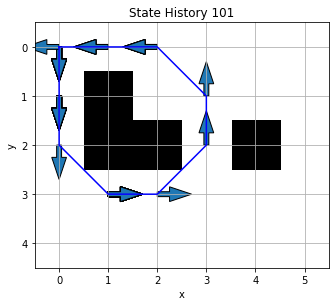

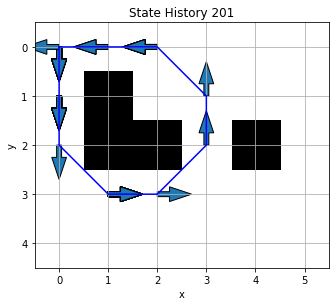

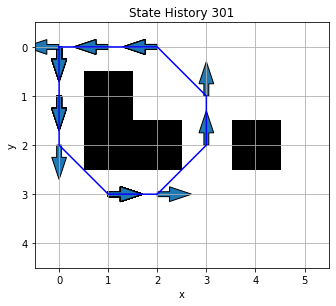

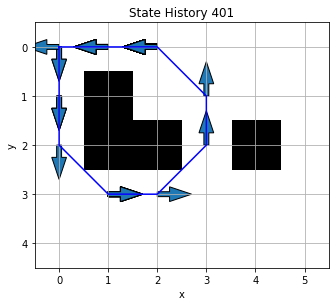

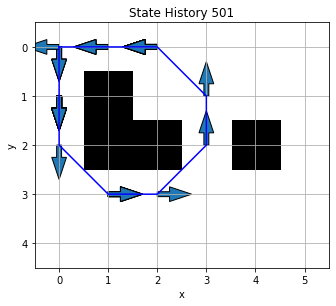

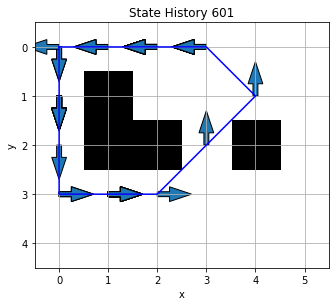

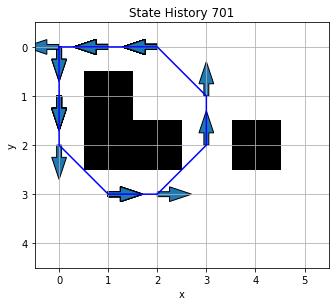

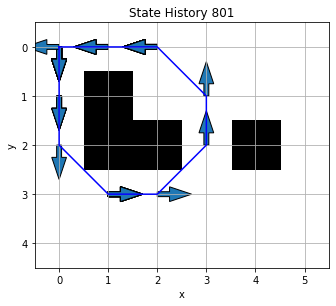

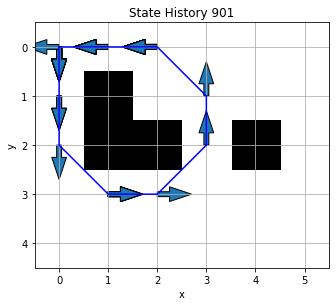

My average= 8.921349999999999


In [23]:
def test_rl_algorithm(rl_agent, car_mdp, initial_state, n_episodes=10000, n_plot=np.inf):
    """
    Code that will be used to test your implementation of ModelBasedRLAgent.

    :param rl_agent: an instance of your ReinforcementLearningAgent class
    :param car_mdp: an instance of CarMDP
    :param init_state: the initial state
    :param n_episodes: number of episodes to use for this test
    :param n_plot: display a plot every n_plot episodes
    :return:
    """
    returns = []
    for episode in range(n_episodes):
        G = 0.  # Keep track of the returns for this episode (discount factor gamma=1)
        # Re-initialize the MDP and the RL agent
        car_mdp.reset();
        action = rl_agent.reset(initial_state)
        terminal = False
        while not terminal:  # Loop until a terminal state is reached
            next_state, reward, terminal, [] = car_mdp.step(action)
            G += reward
            action = rl_agent.next_action(reward, next_state, terminal)
        rl_agent.finish_episode()
        returns += [G]

        # Plot the trajectory every n_plot episodes
        if episode % n_plot == 0 and episode > 0:
            car_mdp.render('State History ' + str(episode + 1))

    return returns


if __name__ == '__main__':

    # Size of the CarMDP map (any cell outside of this rectangle is a terminal state)
    width = 5
    height = 4
    initial_state = (0, 0, 2)  # Top left corner (0, 0), facing "Down" (2)
    obstacles = [(2, 2), (4, 2),(1, 1), (1, 2)]  # Cells filled with obstacles are terminal states
                 
    goal_transition = ((1, 0), (0, 0))  # Transitioning from cell (1, 0) to cell (0, 0) terminates and gives a reward
    p_corr = 0.95  # Probability of actions working as intended
    
  # Create environment
    car_mdp = CarMDP(width, height, obstacles, goal_transition, initial_state, p_corr=p_corr)
  
 # Create RL agent. # You must complete this class in your solution
 
    rl_agent = ModelBasedRLAgent(car_mdp)  
    
   
    student_returns = test_rl_algorithm(rl_agent, car_mdp, initial_state, n_episodes=1000, n_plot=100)
    
    print("My average=", np.average(student_returns))

